# *Outlier separation from arbitrarly shaped clusters with K-means, K-medoids and DBSCAN*
Michał Woźniak

##### **What is this about?**

This notebook explores how you can use clustering techniques to detect problematic datapoints. It proves that they may be a much better alternative to standard outlier detection methods.

##### Loading necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans,DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import KElbowVisualizer

##### Loading and examining the dataset

In [3]:
df=pd.read_csv('dataset.csv',index_col=0)
df.head()

,price,weight,height,capacity
ID,,,,
1,0.058,105.60,1.56,1920
2,0.954,207.68,1.00,384
3,2.385,165.78,1.02,108
4,5.100,221.04,1.05,72
6,1.110,207.68,1.00,384


The dataset used in this notebook is a preprocessed version of real-world data provided  by Trialto Latvia, a third party logistics operator. The original dataset and its description can be accessed [here](https://archive.ics.uci.edu/dataset/585/stock+keeping+units).


The variables in the dataset are the properties of paletts full of given products.
- price: how much is a single product worth
- weight: how heavy is a fully-loaded palett
- height: how high is a fully-loaded palett
- capacity: how many given products can fit on a single palett

##### **Running Linear Regression on a full dataset**
Suppose the task at hand is explaining the price with remaining variables using Ordinary Linear Regression. The estimated formula for price would be:

$$price = \beta_0 + \beta_1*weight + \beta_2*height + \beta_3*capacity + \epsilon$$

In [4]:
X=df[['weight','height','capacity']]
y=df['price']
lin_reg_full=LinearRegression().fit(X,y)
print(f'R^2 = {np.round(100*lin_reg_full.score(X,y),2)}%')

R^2 = 3.97%


The fitted hyperplane fails to explain the variability of price, evident from the coefficient of determination (R^2) being around 4%.

Suppose that given variables in theory should be enough to model the price of a product. What could be the reason for the regression not working then?


One of the possible explanations is the presence of outliers, which heavily impact the estimation of the parameter values.

##### Creating the standardized version of the dataset

The algorithms and methods used in this notebook require uniformely scaled variables. Data standardization is required. This involves subtracting the mean from each value and dividing it by the corresponding standard deviation. Each value becomes a Z-score.

$$x_{std} = \dfrac{x - \mu}{\sigma}$$

In [5]:
dfn=(df-df.mean())/df.std()

#### **Outlier identification**

##### **Z-score method**
This method assumes that any datapoints with Z-score values outside the (-3,3) range are outliers. Any value that is 3 or more standard deviations away from the mean will be considered an outlier. As can be seen in the table with descriptive statistics, some datapoints indeed fit the criteria.

In [6]:
np.round(dfn.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
price,747.0,-0.0,1.0,-0.30,-0.25,-0.17,0.06,22.87
weight,747.0,-0.0,1.0,-1.79,-0.64,-0.22,0.29,4.50
height,747.0,-0.0,1.0,-3.40,-0.50,-0.10,0.01,3.75
capacity,747.0,0.0,1.0,-0.48,-0.41,-0.37,-0.08,11.99


##### Identifying and counting Z-score outliers

In [7]:
dfn['z-score_outlier']=np.where(((dfn['price']>=3)|(dfn['price']<=-3))|
                                ((dfn['weight']>=3)|(dfn['weight']<=-3))|
                                ((dfn['weight']>=3)|(dfn['weight']<=-3))|
                                ((dfn['height']>=3)|(dfn['height']<=-3))|
                                ((dfn['capacity']>=3)|(dfn['capacity']<=-3)),1,0)
outliers=dfn[dfn['z-score_outlier']==1].index
print(f'Outlier count: {len(outliers)} ({int(np.round(100*len(outliers)/len(df),2))}% of total observations)')

Outlier count: 30 (4% of total observations)


Outliers identified with the Z-score method make up roughly 4% of the dataset. That is a worryingly high number, because it indicates that 1 out of every 25 datapoints has at least one extreme value.

##### Visualising data

Scatterplots may reveal some patterns associated with outliers. Maybe they are all grouped together? Or at least easily distinguishable?

As the dataset is 4-dimensional, 6 pairplots have to be analysed (plots forming a triangle on either side of the diagonal).

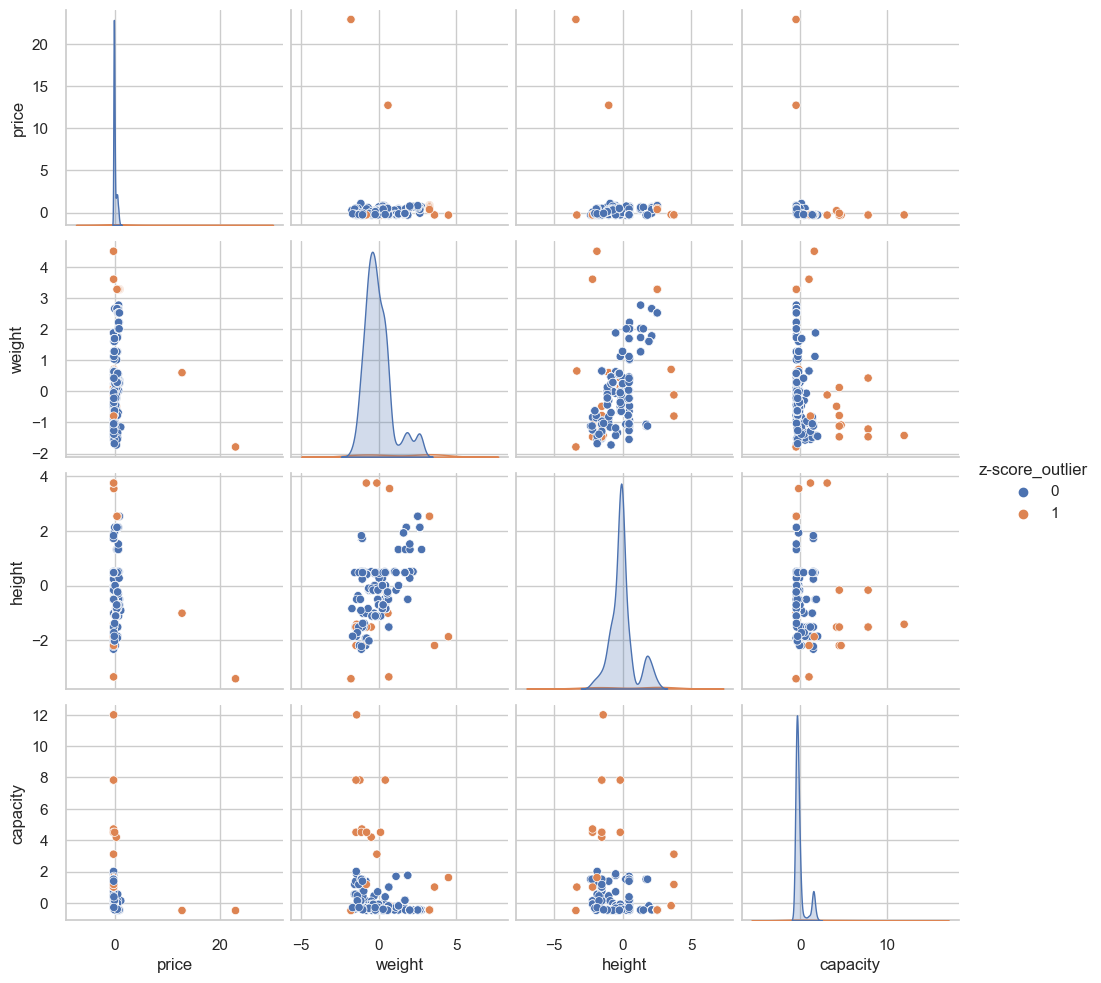

In [8]:
sns.set(style='whitegrid')
sns.pairplot(dfn,diag_kind='kde',hue='z-score_outlier')
plt.show()

Some of the outliers are easily distinguishable from the rest of the datapoints. However, there are no clearly separated clusters consisting only of outliers.

The only thing left to do is  running linear regression once again, this time without those datapoints. This is not the correct approach! Removing that much data from the analysis results in losing a ton of information. Besides that, if the dataset in question is relatively small, it could reduce its size so much that some of the statistical methods will no longer work properly.

In [9]:
df_no_out=df.copy().drop(outliers) # Creating a dataframe without the outliers identified with the Z-score method
X=df_no_out[['weight','height','capacity']]
y=df_no_out['price']
lin_reg_zscore=LinearRegression().fit(X,y)
print(f'R^2 = {np.round(100*lin_reg_zscore.score(X,y),2)}%')

R^2 = 41.75%


Removing the outliers greatly improved the regression results. The R^2 score increased ten-fold. However, it came at a price - loss of a notable chunk of precious data. Therefore, other outlier identification methods should be considered.

##### Assesing cluserability

First, the clusterability of the dataset should be measured. After all, the data may not be fit for clustering methods. 

For this simple analysis, hopkins statistic will be used. It was introduced in 1954 by Hopkins and Skellam. The formula for the statistic is given by:

$$H = \dfrac{\sum_{i=1}^{m}u^d}{\sum_{i=1}^{m}u^d + \sum_{i=1}^{m}w^d}$$
(the variables are listed in the codeblock below, detailed explanation can be found in this awesome [R Journal](https://journal.r-project.org/articles/RJ-2022-055/)).


It is used for testing if the data is uniformly randomly distributed (null hypothesis), and therefore unfit for clustering. In short, it takes a value significantly higher than 0.5 (closer to 1), the dataset should be clusterable.

In [10]:
# As pyclustertend package no longer seems to work, here is the code that calculates the hopkins statistic:
def hopkins_statistic(dfn,subsample_size=0.05,seed=False):
    X=np.array(df.copy()) # Creating an array from the dataset
    n=X.shape[0] # Dataset size
    m=int(subsample_size*n) # Subsample size
    d=X.shape[1] # Dataset dimensionality
    if seed:
        np.random.seed(seed)
    nn=NearestNeighbors(n_neighbors=1,n_jobs=-1)
    nn.fit(X)
    rand_uni=np.random.uniform(X.min(axis=0),X.max(axis=0),size=(m,d)) # Drawing random datapoints from the uniform distribution with the same variability as the dataset
    u=nn.kneighbors(rand_uni,return_distance=True)[0] # Calculating distances between randomly generated points and a corresponding nearest neighbor
    rand_from_X=np.random.choice(n,size=m,replace=False) # Drawing random points from the dataset
    w=nn.kneighbors(X[rand_from_X,:],n_neighbors=2,return_distance=True)[0][:,1] # Calculating distances between randomly drawn points in the dataset and a corresponding nearest neighbor
    U=(u**d).sum() # Summing the 'u' distances
    W=(w**d).sum() # Summing the 'w' distances
    return U/(U+W)

print(f"Hopkins statistic = {np.round(hopkins_statistic(dfn[['price','weight','height','capacity']],seed=2812),2)}")

Hopkins statistic = 1.0


The statistic is approaching the value of 1, which means that the null hypothesis of the dataset being uniformely distributed should be rejected. Hence, the dataset should be easily clusterable.

##### **K-means**

It is probably the most widely known clustering algorithm. In short, it partitions a dataset into k clusters by assigning a centroid to each one. It is done iteratively, until the sum of squared distances between the datapoints and corresponding centroids (WCSS) is minimized (although it may not be the truly optimal outcome - a detailed explanation of how the K-means works and what are its limitations are in these [notes](https://cims.nyu.edu/~sling/MATH-SHU-236-2020-SPRING/MATH-SHU-236-Lecture-6-kmeans.pdf)).

User has to specify how many clusters he wants to be formed. There are many techniques that can help determine which number is the most optimal. Likely the most popular one is the "elbow method". It comes down to choosing the highest k clusters which offer significantly lower WCSS than k-1.

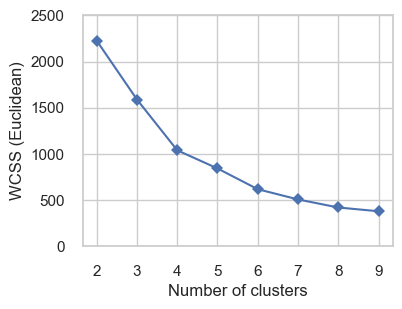

In [11]:
X=dfn[['price','weight','height','capacity']].copy()
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(4,3))
vis=KElbowVisualizer(KMeans(init='random', # by default, the first centroid placement iteration in sklearn is done with the kmeans++ algorithm. This is the original k-means method - randomly selecting first centroids coordinates
                            n_init=100,
                            random_state=2812),
                     k=(2,10),
                     metric='distortion', # Sum of squares of eclidean distances between datapoints and corresponding centroids (WCSS)
                     timings=False,
                     locate_elbow=False,
                     ax=ax,
                     show=False)
ax.set_xticks([2,3,4,5,6,7,8,9])
ax.set_xlabel('Number of clusters')
ax.set_ylim(bottom=0,top=2500)
ax.set_ylabel('WCSS (Euclidean)') 
vis.fit(X)
plt.show()

The optimal number of clusters seems to be k = 4.

In order to verify if the suggested k is indeed optimal, one should use at least more k selection technique. Another popular option would be selecting the k for which the average silhouette score is the highest. The silhouette is is a measure of how similiar a given datapoint is to its cluster in comparison to the rest of the formed clusters. it takes values ranging from -1 to 1, where 1 would mean a perfect match and -1 would signify complete dissimiliarity and a wrong cluster assignment. The metric is the average silhouette of every datapoint. Here is the original [paper](https://wis.kuleuven.be/stat/robust/papers/publications-1987/rousseeuw-silhouettes-jcam-sciencedirectopenarchiv.pdf) about the silhouette.

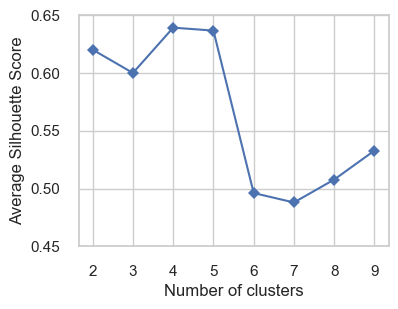

In [12]:
X=dfn[['price','weight','height','capacity']].copy()
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(4,3))
vis=KElbowVisualizer(KMeans(init='random',n_init=100,random_state=2812),
                     k=(2,10),
                     metric='silhouette',
                     timings=False,
                     locate_elbow=False,
                     ax=ax,
                     show=False)
ax.set_xticks([2,3,4,5,6,7,8,9])
ax.set_xlabel('Number of clusters')
ax.set_ylim(bottom=0.45,top=0.65)
ax.set_yticks([0.45,0.5,0.55,0.6,0.65])
ax.set_ylabel('Average Silhouette Score')
vis.fit(X)
plt.show()

The average silhouette score also suggests k = 4.

In [13]:
X=dfn[['price','weight','height','capacity']].copy()
kmeans=KMeans(init='random',n_clusters=4,n_init=100,random_state=2812)
dfn['cluster_kmeans']=kmeans.fit_predict(X)

The primary objective is to form a cluster containing the problematic outliers that are dissimiliar to the rest of the datapoints. Ideally, one of the formed clusters is small and clearly separated from the others.

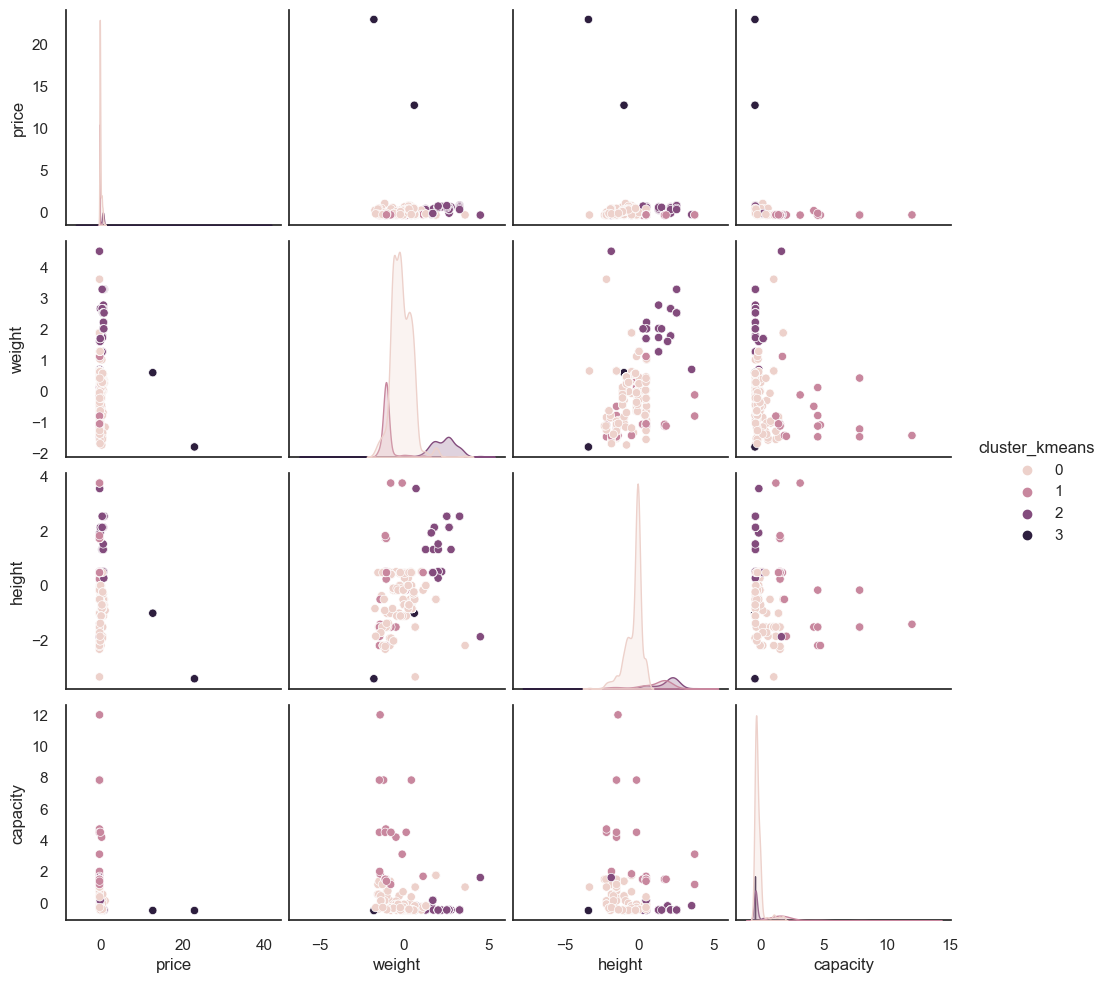

In [14]:
sns.set(style='white')
sns.pairplot(dfn[['price','weight','height','capacity','cluster_kmeans']],diag_kind='kde',hue='cluster_kmeans')
plt.show()

It seems that cluster no. 1 meets that definition. On first glance it consists of two datapoints which are indeed far away from the rest.

In [15]:
dfn[dfn['cluster_kmeans']==3]

,price,weight,height,capacity,z-score_outlier,cluster_kmeans
ID,,,,,,
830,22.873307,-1.785824,-3.398233,-0.481487,1,3
837,12.713292,0.601726,-1.005494,-0.478367,1,3


Both datapoints have one truly extreme value. They also have been marked as outliers with the Z-score method. Therefore, these two points definitely don't ave the same characteristics as the rest of the dataset. Performing linear regression without them should yield much better results. 

In [16]:
df_no_out=df.copy().drop(dfn[dfn['cluster_kmeans']==3].index) # Creating a dataframe without the outliers separated ny K-means
X=df_no_out[['weight','height','capacity']]
y=df_no_out['price']
lin_reg_kmeans=LinearRegression().fit(X,y)
print(f'R^2 = {np.round(100*lin_reg_kmeans.score(X,y),2)}%')

R^2 = 41.16%


The calculated R^2 proves that removing the two outliers identified with K-means yielded almost as good results as deletion of all 30 Z-score outliers. Therefore, while achieving almost the same fit quality, the loss of information was 15 times lower. This is an example of how simple outlier identification methods can be harmful. Some, or even most of the outliers may still be valuable pieces of information and not disrupt the performed analysis.

##### **K-medoids**

Another popular clustering algorithm is the K-medoids. In this notebook, a slightlty modified PAM algorithm will be used as an example. It works pretty similiarly to the K-means algorithm. The main difference is instead of creating a centroid for each cluster, it chooses one of the existing datapoints (called a "medoid").Here is the original K-medoids PAM [paper](https://www.researchgate.net/publication/243777819_Clustering_by_Means_of_Medoids/link/00b7d531493fad342c000000/download?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19). 

In order to determine the optimal k, both the "elbow" method and average silhouette score will be used once more.

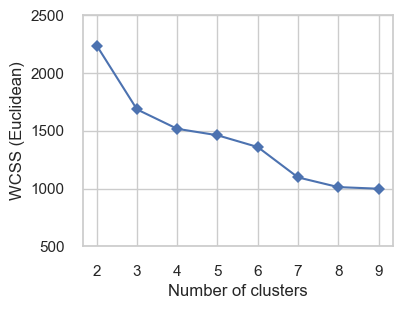

In [17]:
X=dfn[['price','weight','height','capacity']].copy()
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(4,3))
vis=KElbowVisualizer(KMedoids(init='heuristic', # same initial selection of medoids as in the paper (BUILD phase)
                              method='pam', # method from the original paper (SWAP phase)
                              random_state=2812),
                     k=(2,10),
                     metric='distortion', # Sum of squares of eclidean distances between datapoints and corresponding centroids (WCSS)
                     timings=False,
                     locate_elbow=False,
                     ax=ax,
                     show=False)
ax.set_xticks([2,3,4,5,6,7,8,9])
ax.set_xlabel('Number of clusters')
ax.set_ylim(bottom=500,top=2500)
ax.set_yticks([500,1000,1500,2000,2500])
ax.set_ylabel('WCSS (Euclidean)')
vis.fit(X)
plt.show()

The "elbow" method suggests that optimal k = 3.

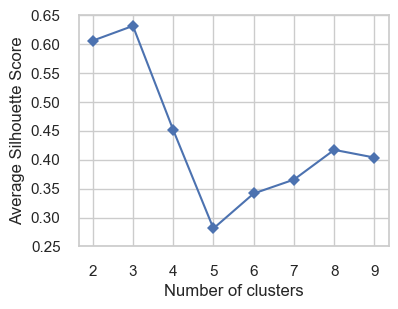

In [18]:
X=dfn[['price','weight','height','capacity']].copy()
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(4,3))
vis=KElbowVisualizer(KMedoids(init='heuristic',
                              method='pam',
                              random_state=2812),
                     k=(2,10),
                     metric='silhouette',
                     timings=False,
                     locate_elbow=False,
                     ax=ax,
                     show=False)
ax.set_xticks([2,3,4,5,6,7,8,9])
ax.set_xlabel('Number of clusters')
ax.set_ylim(bottom=0.3,top=0.65)
ax.set_yticks(np.arange(0.25,0.66,0.05))
ax.set_ylabel('Average Silhouette Score')
vis.fit(X)
plt.show()

Average silhouette score also implies that the opimal k = 3.

In [19]:
X=dfn[['price','weight','height','capacity']].copy()
kmedoids=KMedoids(init='heuristic',method='pam',n_clusters=3,random_state=2812)
dfn['cluster_kmedoids']=kmedoids.fit_predict(X)
dfn_no_out=dfn.copy().drop(outliers)

The primary objective is to form a cluster containing the problematic outliers that are dissimiliar to the rest of the datapoints. Ideally, one of the formed clusters is small and clearly separated from the others.

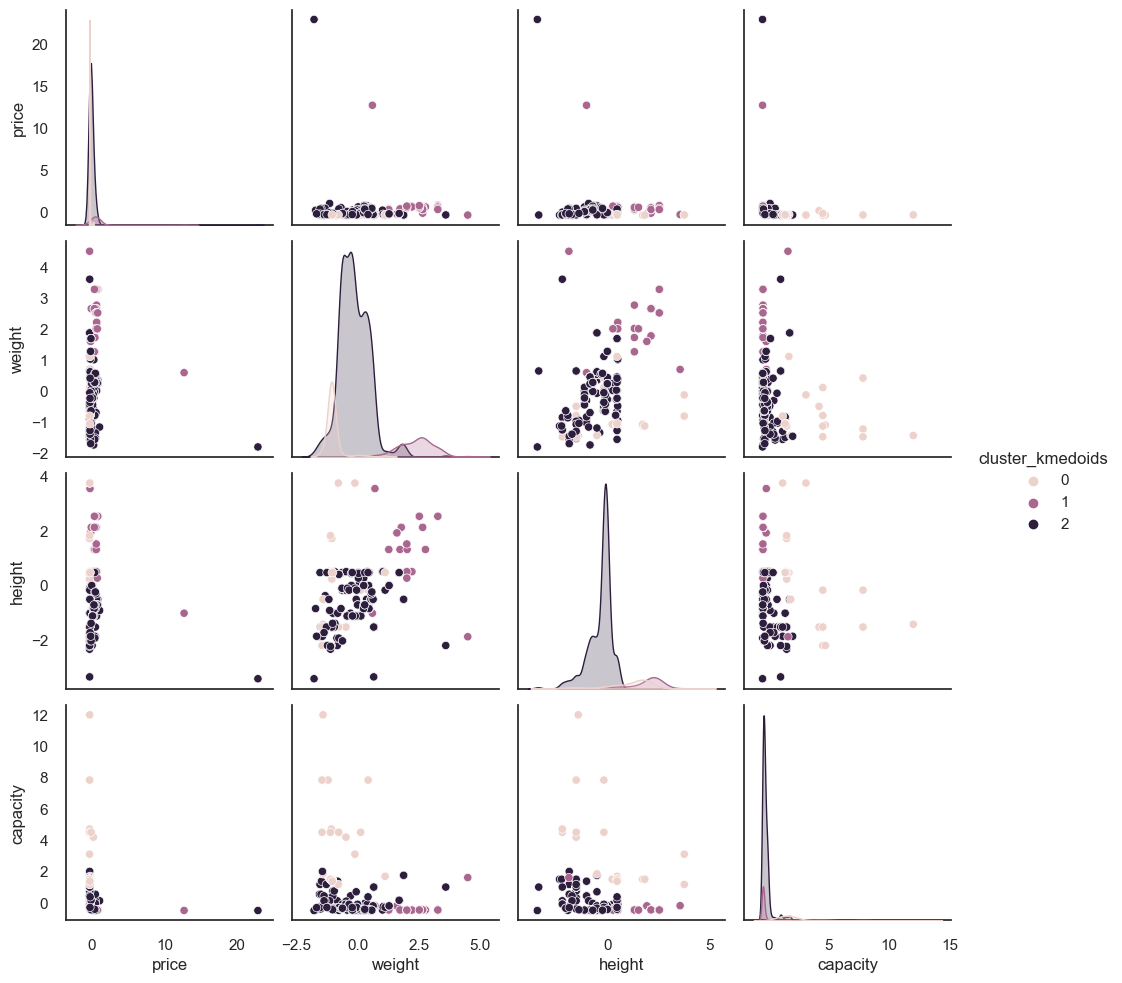

In [20]:
sns.set(style='white')
sns.pairplot(dfn[['price','weight','height','capacity','cluster_kmedoids']],diag_kind='kde',hue='cluster_kmedoids')
plt.show()

K-medoids failed to separate any outliers from the rest of the dataset. This outcome could be expected - K-medoids is usually more robust to outliers, as the choice of medoid is less sensitive to outliers than the calculated centroid. Hence, the outliers are included in the clusters with the rest of the data.


##### Centroid/medoid-based vs. density-based algorithms

The algorithms used by far were either centroid or medoid based. Therefore they relied on choosing a point in space which would be the center of a cluster. However, these methods have one major flaw - they are not fit for creating arbitrarly shaped clusters. If data clusters have irregular, overlapping shapes, these methods may incorrectly label some of the datapoints and form more clusters than needed. Hence, if there are multiple outliers present, these algorithms may form huge clusters containing the problematic observations, even though the desired outcome would be that those datapoints were separated.

**DBSCAN**

In such cases, different clustering methods should be considered. The density-based algorithms operate differently. Instead of relying on finding k central points, they form a number of clusters based on the user defined parameters regarding the desired density of clusters. As an example, the well-established DBSCAN algorithm will be used in this notebook. It takes two parameters: a minimum number of points (minpts) and a maximum distance between neighbouring datapoints (epsilon). Then, it forms clusters consisting of points which all meet the same criteria: having at least minpts amount of neighbors in the same cluster within the epsilon dsitance. The points that do not meet those conditions are labeled as outliers. The complete guide on how the algorithm works can be found in the neatly written original [paper](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf).

The trick of course, is determining the minpts and epsilon. If the dataset has more than 2 dimensions, the rule of thumb is sekecting a minpts that is between the (dimensionality + 1) and (dimensionality * 2). After the minpts is selected, the way of selecting epsilon is the same as in the [paper](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf). In this notebook, the chosen minpts value is 6.

In [28]:
X=dfn[['price','weight','height','capacity']].copy()
nn=NearestNeighbors(n_jobs=-1)
nn.fit(X)
distances=nn.kneighbors(X,n_neighbors=7,return_distance=True) # 6 neighbors (first nearest point is the datapoint itself)
distances=pd.DataFrame(sorted(distances[0][:,6],reverse=True)) # Selecting the distance to the 6th nearest neighbor and sorting

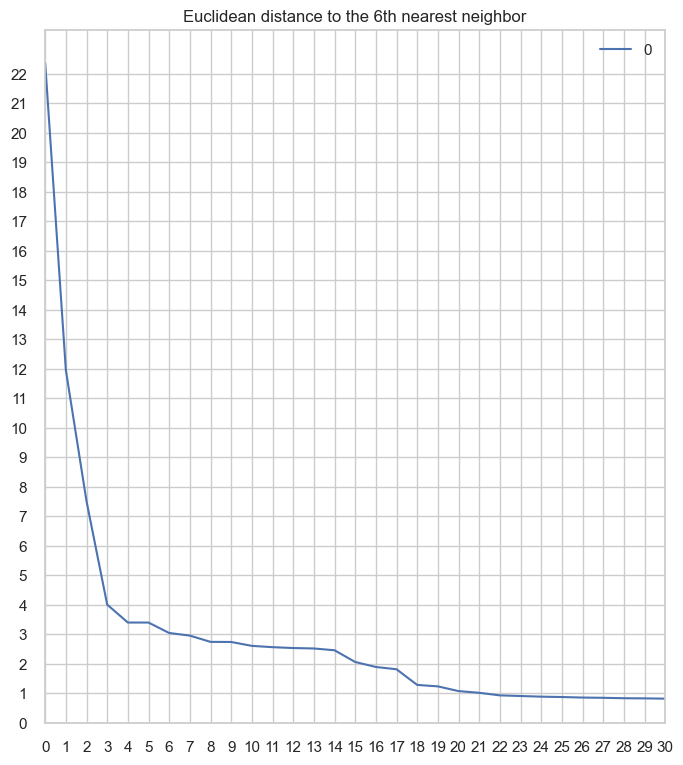

In [130]:
sns.set(style='whitegrid')
fig,ax=plt.subplots(figsize=(8,9))
distances.plot.line(ax=ax)
ax.set_xlim(left=0,right=30)
ax.set_xticks(np.arange(0,31))
ax.set_ylim(bottom=0)
ax.set_yticks(np.arange(0,23,1))
ax.set_title('Euclidean distance to the 6th nearest neighbor')
plt.show()

The threshold distance point can be found at the "elbow" of the graph, which in this case would be 4. However, another point after which the distances start to increase noticably can be seen at rank 18. Selecting a higher maximum distance results in a lower amount of larger cluters. Hence, if epsilon is set at a lower value more outliers should be identified. 

In [35]:
X=dfn[['price','weight','height','capacity']].copy()
epsilon4=distances.iloc[4][0] # Getting the threshold values
epsilon18=distances.iloc[18][0]
dbscan4=DBSCAN(eps=epsilon4,min_samples=6,n_jobs=-1)
dbscan18=DBSCAN(eps=epsilon18,min_samples=6,n_jobs=-1)
dfn['cluster_dbscan_4']=dbscan4.fit_predict(X)
dfn['cluster_dbscan_18']=dbscan18.fit_predict(X)
print(f"""DBSCAN (epsilon = {np.round(epsilon4,2)}) silhoutee score = {np.round(silhouette_score(X,labels=dfn['cluster_dbscan_4']),2)}
DBSCAN (epsilon = {np.round(epsilon18,2)}) silhoutee score = {np.round(silhouette_score(X,labels=dfn['cluster_dbscan_18']),2)}""")

DBSCAN (epsilon = 3.4) silhoutee score = 0.88
DBSCAN (epsilon = 1.29) silhoutee score = 0.43


The less rigorous epsilon value has done a much better clustering job. Notice that the silhouette score is also much higher that what its K-means/K-medoids counterparts managed to achieve.


##### Comparison of DBSCAN with higher and lower epsilon value #####

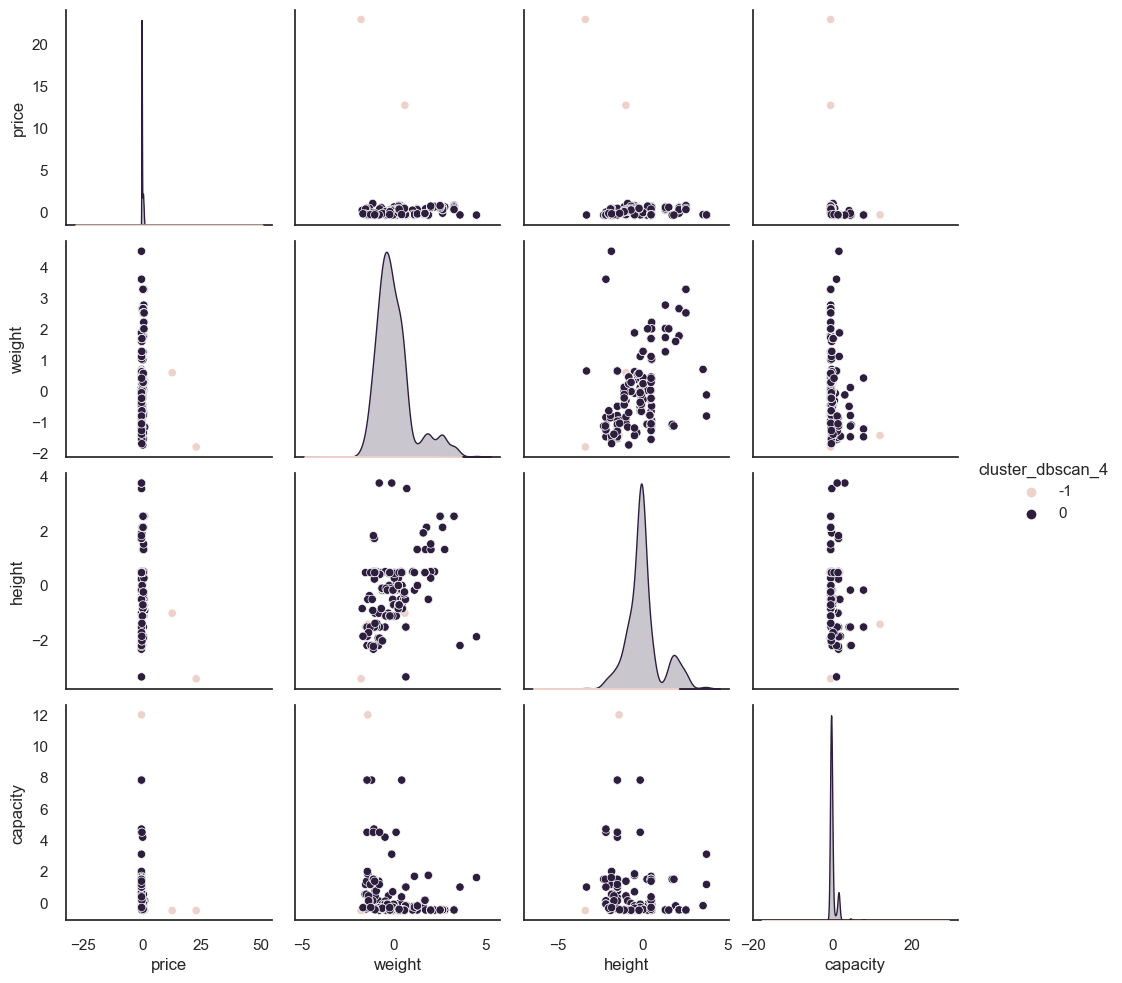

In [36]:
sns.set(style='white')
sns.pairplot(dfn[['price','weight','height','capacity','cluster_dbscan_4']],diag_kind='kde',hue='cluster_dbscan_4')
plt.show()

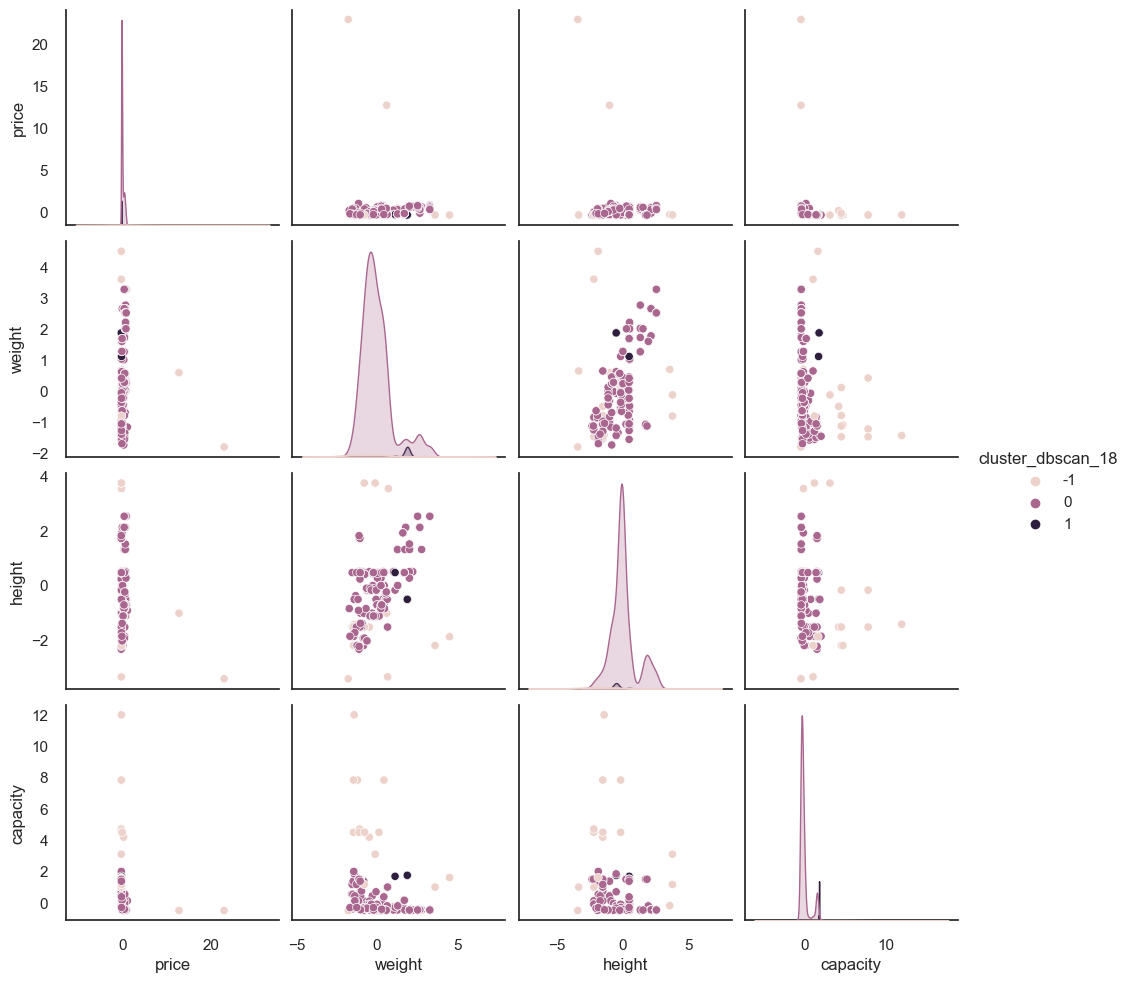

In [37]:
sns.set(style='white')
sns.pairplot(dfn[['price','weight','height','capacity','cluster_dbscan_18']],diag_kind='kde',hue='cluster_dbscan_18')
plt.show()

It seems that the DBSCAN algorithm with higher epsilon value formed a single, huge cluster and identified 3 outliers. This is exactly the situaion where DBSCAN shows what it is capable of doing - forming large, arbitrarly shaped clusters. On the other hand, when given a lower epsilon value, the algorithm formed two clusters (note that the second cluster is really small) and identified many more outliers.

In [43]:
X4=df[['weight','height','capacity']].copy().drop(dfn[dfn['cluster_dbscan_4']==-1].index)
X18=df[['weight','height','capacity']].copy().drop(dfn[dfn['cluster_dbscan_18']==-1].index)
y4=df['price'].copy().drop(dfn[dfn['cluster_dbscan_4']==-1].index)
y18=df['price'].copy().drop(dfn[dfn['cluster_dbscan_18']==-1].index)
lin_reg_dbscan4=LinearRegression().fit(X4,y4)
lin_reg_dbscan18=LinearRegression().fit(X18,y18)
print(f"""R^2 (less rigorous epsilon, {len(dfn)-len(X4)} outliers removed) = {np.round(100*lin_reg_dbscan4.score(X4,y4),2)}%
R^2 (more rigorous epsilon, {len(dfn)-len(X18)} outliers removed) = {np.round(100*lin_reg_dbscan4.score(X18,y18),2)}%""")

R^2 (less rigorous epsilon, 3 outliers detected) = 41.84%
R^2 (more rigorous epsilon, 18 outliers detected) = 45.82%


In both cases, DBSCAN outperformed both other clustering methods and, more importantly, the Z-score method. for the higher epsilon value, only 3 outliers were removed. However, this time OLS managed to deliver a higher R^2 than before (without all 30 Z-score outliers). Loss of information was reduced by 90%. On the other hand, with 18 outliers detected with the more rigorous DBSCAN, OLS managed to explain the variability of price about 10% more efficiently. 

##### Summary #####

This notebook explores the potential of using clustering algorithms as tools for identifying outliers. It manages to show that when working on real-life data, it is advisable to consider those methods instead of relying on techniques such as Z-score rule. Doing so will likely drastically reduce the loss of information, while also doing an overall better job - detecting datapoints which do not have anything in common with the rest.